# Unsupervised Learning Techniques<br>
**Overview**<br>
* Part 1: Clustering Olivetti faces
    * Get data (Olivetti faces)
    * Split into train, test, val sets
    * Cluster images with K-Means, finding optimal amount of clusters
    * Visualize clusters
* Part 2: Using clustering as preprocessing
    * Train Classifier to predict who is being represented in each picture
    * Evaluate on val set
    * Use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set
    * Append featurs from the reduced set to the original features
    * Search for best number of clusters
* Part 3: Gaussian mixture model for Olivetti faces
    * Use PCA to reduce dimensionality (99% variance preserved)
    * Train a Gaussian mixture model on the data
    * Generate new faces and visualize
    * Modify some images and see if the model can distinguish the anomolies

In [268]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline
%reset

Nothing done.


# Part 1: Clustering Olivetti faces
## Step 1
**Get data**

In [269]:
# each instance is 4096 len vector of pixel values
X, y = fetch_olivetti_faces(return_X_y=True)
print(X.shape)

(400, 4096)


## Step 2
**Train, test, val**

In [270]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

To speed things up, use PCA

In [271]:
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

208

## Step 3
**K-means**

In [272]:
max_num_clusters = 200
inertia = []
s_score = []

for i in range(5, max_num_clusters, 5):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X_train_pca)
    inertia.append(kmeans.inertia_)
    s_score.append(silhouette_score(X_train_pca, kmeans.labels_))

    print(f'k = {i}')


k = 5
k = 10
k = 15
k = 20
k = 25
k = 30
k = 35
k = 40
k = 45
k = 50
k = 55
k = 60
k = 65
k = 70
k = 75
k = 80
k = 85
k = 90
k = 95
k = 100
k = 105
k = 110
k = 115
k = 120
k = 125
k = 130
k = 135
k = 140
k = 145
k = 150
k = 155
k = 160
k = 165
k = 170
k = 175
k = 180
k = 185
k = 190
k = 195


**Lets try to use the inertia to find the best amount of clusters**

Text(0, 0.5, 'Inertia')

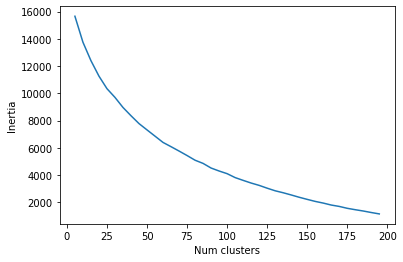

In [273]:
plt.plot(list(range(5, max_num_clusters, 5)), inertia)
plt.xlabel("Num clusters")
plt.ylabel("Inertia")

**Lets also visualize the silhouette score**

Text(0, 0.5, 'Silhouette score')

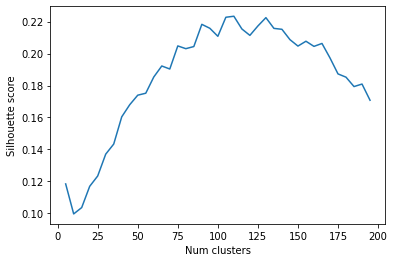

In [274]:
plt.plot(list(range(5, max_num_clusters, 5)), s_score)
plt.xlabel("Num clusters")
plt.ylabel("Silhouette score")

**k ~= 90 give good results**

## Step 4
**Visualize clusters**

Cluster 0


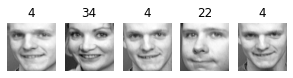

.
.
.

Cluster 10


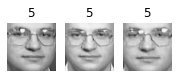

.
.
.

Cluster 20


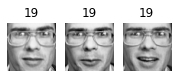

.
.
.

Cluster 30


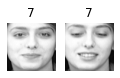

.
.
.

Cluster 40


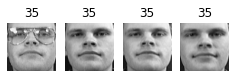

.
.
.

Cluster 50


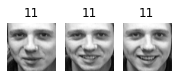

.
.
.

Cluster 60


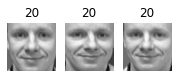

.
.
.

Cluster 70


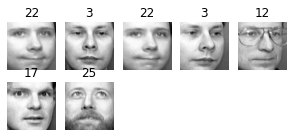

.
.
.

Cluster 80


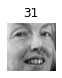

.
.
.



In [275]:
best_kmeans = KMeans(n_clusters=90, random_state=42).fit(X_train_pca)

labels = best_kmeans.labels_
centroids = best_kmeans.cluster_centers_
u_labels = np.unique(labels)

def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

# show just some clusters
for id_ in u_labels[::10]:
    print("Cluster", id_)
    in_cluster = best_kmeans.labels_==id_
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)
    print('.\n.\n.\n')

# Part 2: Using clustering as preprocessing
## Step 5
**Train classifier and predict faces**

In [276]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42).fit(X_train, y_train)
predictions = rf_clf.predict(X_val)
acc = accuracy_score(y_val, predictions)

print(f'{acc*100}%')

print(predictions[:10])
print(y_val[:10])

95.0%
[28  7 13 19 24 18 20 22  3 27]
[28  7 13 19 24 18 20 22  3 27]


## Step 6
**K-means to reduce dimensionality, then train on reduced set**

In [277]:
X_train_kmeans = best_kmeans.transform(X_train_pca)

X_val_kmeans = best_kmeans.transform(X_val_pca)

In [278]:
rf_clf_red = RandomForestClassifier(n_estimators=150).fit(X_train_kmeans, y_train)
predictions = rf_clf_red.predict(X_val_kmeans)
acc = accuracy_score(y_val, predictions)

print(f'{acc*100}%')

print(f'Pred:\t\t{predictions[:10]}')
print(f'Actual:\t\t{y_val[:10]}')

76.66666666666667%
Pred:		[28  7 13 12 24 18 20 12  3 27]
Actual:		[28  7 13 19 24 18 20 22  3 27]


We're loosing lots of performance so lets try out some new cluster numbers

In [279]:
for n_clusters in range(5, 100, 10):

    rf_n = RandomForestClassifier(n_estimators=150)
    rf_n.fit(X_train_kmeans, y_train)
    pred = rf_n.predict(X_val_kmeans)
    acc = accuracy_score(y_val, pred)
    print(f'k={n_clusters}, acc={acc}')

k=5, acc=0.8
k=15, acc=0.7666666666666667
k=25, acc=0.7833333333333333
k=35, acc=0.8166666666666667
k=45, acc=0.8166666666666667
k=55, acc=0.8
k=65, acc=0.7666666666666667
k=75, acc=0.8166666666666667
k=85, acc=0.7666666666666667
k=95, acc=0.8


Yikes! We still get a big loss in accuracy, meaning we're losing too much information when clustering

## Step 7
**Append reduced set to full set, see accuracy**

In [280]:
X_train_append = np.c_[X_train_pca, X_train_kmeans]
X_val_append = np.c_[X_val_pca, X_val_kmeans]

for n_clusters in range(5, 100, 10):

    rf = RandomForestClassifier(n_estimators=150, random_state=42)
    rf.fit(X_train_append, y_train)
    pred = rf.predict(X_val_append)
    acc = accuracy_score(y_val, pred)
    print(f'k={n_clusters}, acc={acc}')

k=5, acc=0.8833333333333333
k=15, acc=0.8833333333333333
k=25, acc=0.8833333333333333
k=35, acc=0.8833333333333333
k=45, acc=0.8833333333333333
k=55, acc=0.8833333333333333
k=65, acc=0.8833333333333333
k=75, acc=0.8833333333333333
k=85, acc=0.8833333333333333
k=95, acc=0.8833333333333333


Better, but still not as good as without clustering. The clusters aren't helpful in predictions

# Part 3: Gaussian mixture model for Olivetti faces
## Step 8
**Use PCA to reduce dimensionality, train GMM on data**

In [281]:
# (reduced dataset with pca in X_train_pca)
# 40 componenets for the 40 different faces
gm = GaussianMixture(n_components=40, random_state=42).fit(X_train_pca)

## Step 9
**Generate new faces and visualize**

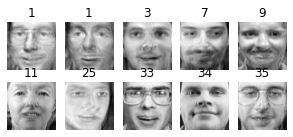

In [282]:
sample_faces_X_reduced, sample_faces_y_reduced = gm.sample(10)

samples_faces_X = pca.inverse_transform(sample_faces_X_reduced)

plot_faces(samples_faces_X, sample_faces_y_reduced)

## Step 10
**Modify some images and see if the model can distinguish the anomolies**

(3, 4096)
Rotated


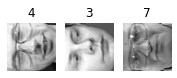

Flipped


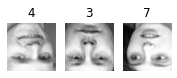

Darkened


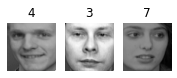

In [283]:
n_bad = 3

# rotate
X_train_rotate = X_train[:n_bad].copy().reshape((-1, 64, 64))
 
print(X_train[:n_bad].shape)

# for each image
for i in range(images_reshaped.shape[0]):
    image = images_reshaped[i, :, :]

    # for each row in each image, make it the column in images_reshaped
    for row_idx, row in enumerate(image):
        column = row.reshape((64, ))
        X_train_rotate[i, :, row_idx] = column

# flip
X_train_flip = X_train[:n_bad].copy()
for i in range(X_train_flip.shape[0]):
    X_train_flip[i, :] = X_train_flip[i, ::-1]

# darken
X_train_darken = X_train[:n_bad].copy()
X_train_darken[:, 1:-1] *= 0.5


print('Rotated')
plot_faces(X_train_rotate, y_train[:n_bad])
print('Flipped')
plot_faces(X_train_flip, y_train[:n_bad])
print('Darkened')
plot_faces(X_train_darken, y_train[:n_bad])


X_train_bad = np.concatenate([X_train_rotate.reshape((3, 4096)), X_train_flip, X_train_darken])

In [284]:
good_scores = gm.score_samples(X_train_pca[:9])
print(f'--------------Good Image Scores--------------\n{good_scores}')

X_bad_pca = pca.transform(X_train_bad)
bad_scores = gm.score_samples(X_bad_pca)
print(f'--------------Bad Image Scores--------------\n{bad_scores}')

--------------Good Image Scores--------------
[1185.73537921 1114.601231   1170.7465256  1114.60123578 1185.9423354
 1114.60123015 1143.82459321 1185.73537921 1155.86248886]
--------------Bad Image Scores--------------
[-25530419.19918699 -42074412.36562639 -20697750.34438269
 -32716764.27613695 -29636849.95007736 -29038370.76025432
 -21987260.14569854 -16572689.28848326 -19669128.17835453]


**The bad images have very low scores, which means that the GMM thinks that they are likely to be outliers**